# Cross validation analysis of final evaluation results between different techniques

Tong Shu Li<br>
Created on: 2015-10-08<br>
Last updated: 2015-11-24

The team at UTexas was kind enough to send their final predictions for the CID task. We will compare their results to the crowd's and see where their outputs differed.

In [1]:
from collections import defaultdict
from itertools import combinations

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import numpy as np
import os
import pandas as pd
import pickle
import rpy2
import rpy2.robjects as robjects
import seaborn as sns
import sys

In [2]:
RAND_KEY = np.random.RandomState(20151007)

matplotlib.rcParams.update({'font.size': 12})
TRIPLE = ["pmid", "chemical_id", "disease_id"]
pd.options.mode.chained_assignment = None
pd.set_option("max_colwidth", 55)

In [3]:
%matplotlib inline
%load_ext rpy2.ipython

In [4]:
sys.path.append("..")

In [5]:
from src.lingpipe.file_util import read_file
from src.lingpipe.file_util import save_file

from src.data_model import Ontology_ID
from src.data_model import Relation
from src.data_model import parse_input
from src.data_model import parse_file
from src.data_model import Annotation

from src.eval_perf import performance
from src.eval_perf import official_F_score
from src.parse_mesh import load_mesh
from src.get_mesh_terms import Article

from src.get_AUC_value import get_AUC_value

---

## Global functions

In [6]:
def make_df(triples):
    """Converts a given set of (pmid, chemical_id, disease_id)
    triples into a three column dataframe."""
    return pd.DataFrame(list(triples), columns = TRIPLE)

In [7]:
def get_triples(dataframe):
    return set(
        dataframe[TRIPLE].apply(
            lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]),
            axis = 1
        )
    )

In [8]:
def expand_df(column, df):
    """Given a dataframe where one column is a list of values,
    expands the dataframe so that one new row is created for
    each item in the original list."""
    other_columns = df.columns.difference(pd.Index([column]))    
    
    res = []
    for idx, row in df.iterrows():
        # make the list in this cell into a vertical dataframe with one column
        vals = pd.DataFrame(row[column], columns = [column])
        
        # copy all the other columns over
        for col in other_columns:
            vals.loc[:, col] = row[col]
            
        res.append(vals)
        
    return pd.concat(res).reset_index(drop = True)

### Read the gold standard and various solutions

In [9]:
def read_output(fname):
    """Read only the CID relations from a Pubtator-formatted
    text file.
    """
    temp = defaultdict(list)
    for line in read_file(fname):
        vals = line.split("\t")
        
        if len(vals) > 1 and vals[1] == "CID":
            temp["pmid"].append(int(vals[0]))
            temp["chemical_id"].append(Ontology_ID(vals[2]).flat_repr)
            temp["disease_id"].append(Ontology_ID(vals[3]).flat_repr)
            
            if len(vals) > 4:
                temp["threshold"].append(float(vals[4]))

    return pd.DataFrame(temp)

In [10]:
def read_gold_standard(dataset, file_format = "list"):
    assert dataset in ["training", "development", "test"]
    assert file_format in ["list", "dict"]
    
    fname = "parsed_{0}_set_{1}.pickle".format(dataset, file_format)
    
    save_loc = os.path.abspath(os.path.join("..", "data", "gold_standard", fname))
    
    fname = "CDR_{0}Set.txt".format(dataset.capitalize())
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard"))
    
    return parse_file(save_loc, loc = loc, fname = fname,
        is_gold = True, return_format = file_format, fix_acronyms = False)

In [11]:
def has_concept(paper, concept_id):
    concepts = set()
    for annot in paper.annotations:
        concepts |= set([iden.flat_repr for iden in annot.uid if iden.uid_type == "MESH"])
    
    return concept_id in concepts

In [12]:
def check_exists(df, reference):
    for col in ["chemical", "disease"]:
        df.loc[:, "{}_exists".format(col[:4])] = df[TRIPLE].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

### Read the PMID mappings

In [13]:
paper_mapping = save_file("testset_mapping.pickle")

### Read the gold standard

In [14]:
eval_gold = read_gold_standard("test", file_format = "dict")

In [15]:
fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
gold_std = read_output(fname)

### Grab the official MeSH terms for the testset and save to pickle

In [16]:
def grab_mesh(papers):
    loc = os.path.abspath(os.path.join("..", "data", "gold_standard", "testset_mesh_terms.pickle"))

    res = save_file(loc)
    if res is not None:
        return res
    
    res = dict()
    for pmid in papers:
        res[pmid] = Article(pmid)
        
    save_file(loc, res)
    return res

In [17]:
mesh_terms = grab_mesh(set(eval_gold.keys()))

### Read the crowd's results

In [18]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "crowd_testset.pickle"))
crowd_full = save_file(loc)
crowd_res = save_file("testset_final_res.pickle")

In [19]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "abstract_relation_res.tsv"))

abs_res = pd.read_csv(loc, sep = '\t', dtype = {"unit_id": str})
abs_res = abs_res.rename(columns = {"percent_agree": "norm_conf_score",
                                   "unit_id": "unit_ids"})

abs_res.loc[:, "pmid"] = abs_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])
abs_res.loc[:, "unit_ids"] = abs_res.loc[:, "unit_ids"].astype(int)

In [20]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "results", "sentence_relation_abs_res.tsv"))
sent_res = pd.read_csv(loc, sep = '\t', dtype = {"unit_ids": str})

sent_res = sent_res.rename(columns = {"conf_score": "norm_conf_score",
                                      "score_vote_max": "num_votes"})

sent_res.loc[:, "pmid"] = sent_res.loc[:, "pmid"].map(lambda val: paper_mapping[val])

### Read UTexas results

In [21]:
loc = os.path.abspath(os.path.join("..", "data", "utexas", "texas_full_testset.pickle"))
texas_full = save_file(loc)

loc = os.path.abspath(os.path.join("..", "data", "utexas", "CDR_TestSet.BiC.V.CID.Run3.txt"))
ut_res = read_output(loc)

### Read BeFree's results

In [22]:
fname = os.path.abspath(os.path.join("..", "data", "befree", "final_eval", "befree_testset_results.txt"))
befree_res = read_output(fname)

befree_res.loc[:, "pmid"] = befree_res["pmid"].map(lambda val: paper_mapping[val])
befree_res["threshold"] = 1

#----------------------------------

def get_befree():
    loc = os.path.join("..", "data", "befree", "final_eval")

    save_loc = os.path.abspath(os.path.join(loc, "befree_testset_full.pickle"))
    res = save_file(save_loc)
    if res is not None:
        return res

    befree_full = parse_input(os.path.abspath(loc), "befree_testset_results.txt",
                         is_gold = True, return_format = "dict", fix_acronyms = False)

    temp = dict()
    for pmid, paper in befree_full.items():
        paper.pmid = paper_mapping[pmid]
        temp[paper_mapping[pmid]] = paper

    save_file(save_loc, temp)
    return temp
    
befree_full = get_befree()

---

## Overall performance against the gold standard

Using the official evaluation of the CID relation performance, how did each solution do?

### Get the gold standard triples

In [23]:
gold_triples = get_triples(gold_std)

### Crowd performance

In [24]:
official_res = official_F_score("num_votes", gold_triples, crowd_res)

In [25]:
official_res

,F_score,precision,recall,threshold
0,0.267624,0.162805,0.751407,0
1,0.356317,0.236486,0.722326,1
2,0.444779,0.327426,0.693246,2
3,0.496480,0.410288,0.628518,3
4,0.505929,0.475640,0.540338,4
5,0.465066,0.556136,0.399625,5


### Texas performance

In [26]:
official_F_score("threshold", gold_triples, ut_res)

,F_score,precision,recall,threshold
0,0.570252,0.556747,0.584428,0.30
1,0.585269,0.618600,0.555347,0.65
2,0.520915,0.642366,0.438086,0.75


### BeFree performance

In [27]:
official_F_score("threshold", gold_triples, befree_res)

,F_score,precision,recall,threshold
0,0.428571,0.486874,0.382739,1


My calculations show that BeFree's official published performance (F 0.4281) is slightly worse than what I have calculated, despite my method accurately reproducing both UTexas's and our results. Perhaps Alex sent me a slightly modified version of the data they submitted?

In [28]:
crowd_trip = get_triples(crowd_res.query("num_votes >= 4"))
befree_trip = get_triples(befree_res)
texas_trip = get_triples(ut_res)

### Venn diagram of relations for Crowd and Befree, full workflow

In [29]:
# make venn diagram for relations for the full workflow

# fnames = ["temp/gold_trips.txt", "temp/crowd_trips.txt", "temp/befree_trips.txt", "temp/texas_trips.txt"]
# dfs = [gold_std, crowd_res.query("num_votes >= 4"), befree_res, ut_res]
# for fname, df in zip(fnames, dfs):
#     df[TRIPLE].to_csv(fname, sep = "|", header = False, index = False)

### Relation comparison: full workflow for crowd and befree
<img src="../data/final_eval/analysis/testset_crowd_befree_relations.png" style="width: 500px;">

This is for the full workflow output of both BeFree and the crowd. Crowd relations are filtered to only those with >= 4 votes.

### Relation comparison: full workflow for crowd, befree, and texas
<img src="../data/notebook/testset_all_cross_validation.png" style="width: 500px;">

The full outputs of the programs are fine, but since many of these things are NER errors, it would be much better to filter those and then compare.

---

## Performance on a subset of relations where the annotations were perfectly identified

Since we have seen that NER has a huge influence on the performance, we will look backwards to see what performance was like on relations where both the chemical and disease were perfectly identified (i.e. the annotations all match the gold standard).

In [30]:
def extract_ids(annotations):
    concepts = defaultdict(set)
    for annot in annotations:
        concepts[annot.stype].add(annot.uid)

    return concepts

def expand_set(vals):
    res = set()
    for v in vals:
        res |= v
        
    return res

In [31]:
def find_perfect_concepts(predict, gold_std):
    """Finds the concepts having the exact same annotations
    in both data sets.
    """
    res = dict()
    for pmid, gold_paper in gold_std.items():
        paper = predict[pmid]

        # annotations
        predict_annot = set(paper.annotations)
        gold_annot = set(gold_paper.annotations)
        
        shared_concepts = extract_ids(gold_annot & predict_annot)
        missed_concepts = extract_ids(gold_annot ^ predict_annot)
        
        perf_chem = shared_concepts["chemical"] - missed_concepts["chemical"]
        perf_dise = shared_concepts["disease"] - missed_concepts["disease"]
        
        chems = expand_set(perf_chem)
        dises = expand_set(perf_dise)

        res[pmid] = (chems, dises)

    return res

def get_perf_subset_triples(perf_concepts):
    res = set()
    for pmid, (chem, dise) in perf_concepts.items():
        res |= set([(pmid, c.flat_repr, d.flat_repr) for c in chem for d in dise])
        
    return res

In [32]:
def ner_filter(predict_full, predict_df, gold_full, gold_df):
    """Given a dataframe of a solution's predicted CID relations,
    applies a NER filter with the gold standard to return only those
    relations which were generated using perfectly annotated concepts.
    """
    # what were the concepts perfectly annotated by the predictions and gold std?
    common_concepts = find_perfect_concepts(predict_full, gold_full)
    
    # what are all possible triples using the perfect concepts?
    poss_good_trips = get_perf_subset_triples(common_concepts)
    
    poss_df = make_df(poss_good_trips)
    
    # filter predictions and gold standard using the set of possible triples
    predict_sub = pd.merge(predict_df, poss_df, how = "inner", on = TRIPLE)
    gold_sub = pd.merge(gold_df, poss_df, how = "inner", on = TRIPLE)
    
    return (predict_sub, gold_sub)

In [33]:
crowd_no_ner, crowd_good_gold = ner_filter(crowd_full, crowd_res, eval_gold, gold_std)

In [34]:
len(crowd_good_gold["pmid"].unique())

290

In [35]:
crowd_no_ner_perf = official_F_score("num_votes", get_triples(crowd_good_gold), crowd_no_ner)
crowd_no_ner_perf

,F_score,precision,recall,threshold
0,0.318346,0.189305,1.000000,0
1,0.434339,0.280240,0.964948,1
2,0.540541,0.381356,0.927835,2
3,0.615958,0.482477,0.851546,3
4,0.645447,0.565015,0.752577,4
5,0.603732,0.645540,0.567010,5


These results are slightly better than the simple NER filtering that I was using before, where I only check whether the concept was identified at all in the paper. However, the performance is basically the same, still in the low 0.6 F range.

In [36]:
texas_no_ner, texas_good_gold = ner_filter(texas_full, ut_res, eval_gold, gold_std)

texas_no_ner_perf = official_F_score("threshold", get_triples(texas_good_gold), texas_no_ner)
texas_no_ner_perf

,F_score,precision,recall,threshold
0,0.668800,0.622951,0.721934,0.30
1,0.668354,0.653465,0.683938,0.65
2,0.600966,0.682018,0.537133,0.75


In [37]:
befree_no_ner, befree_good_gold = ner_filter(befree_full, befree_res, eval_gold, gold_std)

befree_no_ner_perf = official_F_score("threshold", get_triples(befree_good_gold), befree_no_ner)
befree_no_ner_perf

,F_score,precision,recall,threshold
0,0.588774,0.622276,0.558696,1


In [38]:
def pair_perf_plot(df1, df2, title, xlabel, fontsize, figsize, linewidth, fname = None):
    """Plots two pairs of performances on the same figure.
    
    Colors are specified manually, as are legend values.
    """    
    colors = {
        "f_score": "blue",
        "precision": "green",
        "recall": "red"
    }
    
    labels = {
        "recall": Patch(color = colors["recall"], label = "Recall"),
        "precision": Patch(color = colors["precision"], label = "Precision"),
        "f_score": Patch(color = colors["f_score"], label = "F-score"),
        "no_ner": Line2D([], [], color = "black", linestyle = "-", linewidth = linewidth,
                      label = "Without NER filter"),
        "yes_ner": Line2D([], [], color = "black", linestyle = "--", linewidth = linewidth,
                       label = "With NER filter")
    }

    matplotlib.rcParams.update({"font.size": fontsize})

    # order determined by trial and error..
    color = [colors["f_score"], colors["precision"], colors["recall"]]

    ax = df1.plot(
        x = "threshold", figsize = figsize, title = title,
        ylim = (0, 1.05), linewidth = linewidth, legend = False, color = color
    )

    ax = df2.plot(
        ax = ax, x = "threshold", figsize = figsize, title = title,
        linestyle = "--", ylim = (0, 1.05), linewidth = linewidth,
        legend = False, color = color
    )

    ax.set_xlabel(xlabel)
    
    plt.legend(loc = "best", handles = [
            labels["recall"], labels["precision"], labels["f_score"],
            labels["no_ner"], labels["yes_ner"]
        ]
    )
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

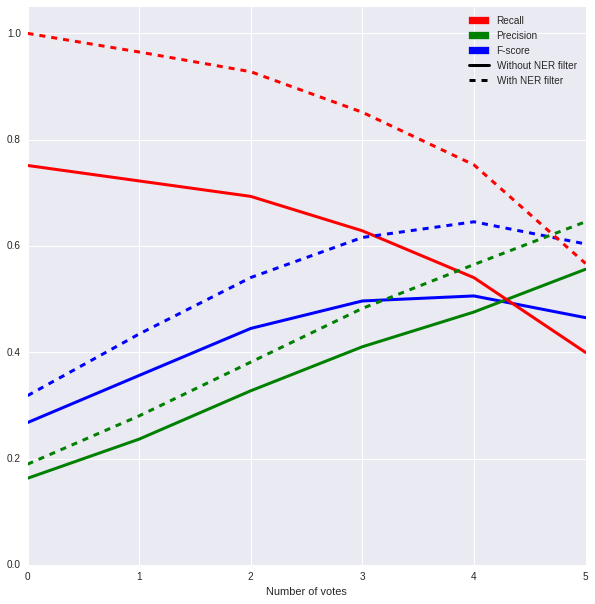

In [39]:
# official figure for database submission
# demonstrating the effect of the NER filter on performance
pair_perf_plot(official_res, crowd_no_ner_perf,
    "",
    "Number of votes", 18, (10, 10), 3, "crowd_testset_perf.png")

### ROC curves

In [40]:
temp = pd.merge(crowd_res[TRIPLE + ["num_votes"]], gold_std, how = "outer", on = TRIPLE)

In [41]:
temp.loc[:, "num_votes"] = temp.loc[:, "num_votes"].fillna(0)

In [42]:
temp.loc[:, "in_gold"] = temp.loc[:, TRIPLE].apply(
    lambda r: int((r["pmid"], r["chemical_id"], r["disease_id"]) in gold_triples),
    axis = 1
)

In [43]:
# temp.to_csv("true_roc.tsv", sep = '\t', index = False)

In [44]:
# AUC value for no NER filtering
get_AUC_value(temp, "num_votes", "in_gold")

0.6934884421117169

In [45]:
temp = pd.merge(crowd_no_ner[TRIPLE + ["num_votes"]], crowd_good_gold, how = "outer", on = TRIPLE)

In [46]:
sub = get_triples(crowd_good_gold)
temp.loc[:, "in_gold"] = temp.loc[:, TRIPLE].apply(
    lambda r: int((r["pmid"], r["chemical_id"], r["disease_id"]) in sub),
    axis = 1
)

In [47]:
# temp.to_csv("no_ner_roc.tsv", sep = '\t', index = False)

In [48]:
get_AUC_value(temp, "num_votes", "in_gold")

0.8763695655411006

**Actual paired ROC curve was generated using R script.**

---

## Venn diagram of relations with NER filter

Relations generated using concepts that are perfectly annotated in all solutions with respect to gold standard.

In [49]:
crowd_conc = find_perfect_concepts(crowd_full, eval_gold)
befree_conc = find_perfect_concepts(befree_full, eval_gold)
texas_conc = find_perfect_concepts(texas_full, eval_gold)

common_conc = {
    pmid: tuple([crowd_conc[pmid][i] & befree_conc[pmid][i] & texas_conc[pmid][i] for i in range(2)])
    for pmid in eval_gold.keys()
}

poss_good_trips = get_perf_subset_triples(common_conc)
poss_df = make_df(poss_good_trips)

gold_sub = pd.merge(gold_std, poss_df, how = "inner", on = TRIPLE)
crowd_sub = pd.merge(crowd_res, poss_df, how = "inner", on = TRIPLE)
befree_sub = pd.merge(befree_res, poss_df, how = "inner", on = TRIPLE)
texas_sub = pd.merge(ut_res, poss_df, how = "inner", on = TRIPLE)

In [50]:
# make venn diagram for relations for the full workflow

# fnames = ["temp/gold_trips.txt", "temp/crowd_trips.txt", "temp/befree_trips.txt", "temp/texas_trips.txt"]
# dfs = [gold_sub, crowd_sub.query("num_votes >= 4"), befree_sub, texas_sub]
# for fname, df in zip(fnames, dfs):
#     df[TRIPLE].to_csv(fname, sep = "|", header = False, index = False)

<img src="../data/final_eval/analysis/testset_crowd_befree_common_filtered_relations.png" style="width: 500px;">

This is for the NER filtered output of BeFree and crowd. Relations were subsetted on concepts which were perfectly matching gold in both solutions.

<img src="../data/final_eval/analysis/testset_all_no_ner_cross_validation.png" style="width: 500px;">

This is for the NER filtered output of all 3 solutions. Relations were subsetted on concepts which were perfectly matching gold in all solutions.

## Error analysis

Null hypothesis: the origin of a relation is independent of the category that the relation belongs to (true positive, false positive, false negative).

We use the Chi square test to determine whether the null hypothesis is true. We will group CID and sentence bound relations together.

In [51]:
def converter(pmid, poss_relations):
    return [Relation(pmid, rel[0], rel[1]) for rel in poss_relations]

def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "sent",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return "|".join(ans)

In [52]:
def single_triple(row):
    return (int(row["pmid"]), row["chemical_id"], row["disease_id"])

def make_summary(predictions, gold_std):
    temp = pd.merge(predictions[TRIPLE], gold_std[TRIPLE], how = "outer", on = TRIPLE)
    
    pred_trip = get_triples(predictions)
    gold_trip = get_triples(gold_std)
    
    temp.loc[:, "in_gold"] = temp.loc[:, TRIPLE].apply(
        lambda row: single_triple(row) in gold_trip, axis = 1
    )
    
    temp.loc[:, "in_predict"] = temp.loc[:, TRIPLE].apply(
        lambda row: single_triple(row) in pred_trip, axis = 1
    )
    
    temp.loc[:, "rel_origin"] = temp.loc[:, TRIPLE].apply(
        lambda row: rel_origin(single_triple(row), eval_gold[row["pmid"]]), axis = 1
    )
    
    temp.loc[:, "pmid"] = temp.loc[:, "pmid"].astype(int)
    
    return temp

In [53]:
def category_splitter(predict_res, gold_std, option = ""):
    """A generator for categories of relations."""
    predict = make_summary(predict_res, gold_std)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    for etype, val in zip(error_type, vals):
        sub = predict.query("in_gold == {} and in_predict == {}{}".format(
            val[0], val[1], option
        )).dropna()
        
        yield (etype, sub)

In [54]:
def two_samp_test(res, test_type):
    assert test_type in ["t.test", "wilcox.test"]
    test = robjects.r[test_type]
    
    #determined empirically
    cover = {
        "t.test": 8,
        "wilcox.test": 6
    }    
    
    for a, b in combinations(["TP", "FP", "FN"], 2):
        print("{} between {} and {}".format(test_type, a, b))
        result = test(res[a], res[b])
        # don't print the acutal series themselves
        # overwriting with zero suppresses superfluous output
        result[cover[test_type]] = 0

        print(result)
        print("-----------------------------")

In [55]:
def test_origin(pred_res, gold_std):
    """Apply the Chi-square test to see if a relation's
    origin is independent of the category of error it
    belongs to.
    """
    chisqtest = robjects.r["chisq.test"]
    
    res = dict()
    for etype, sub in category_splitter(pred_res, gold_std):
        res[etype] = sub["rel_origin"].value_counts()[["sent", "abs"]]
        
    res = pd.DataFrame(res).T
    
    print(chisqtest(res))
    
    return res

In [56]:
# hypothesis: relation origin is independent of category the relation ends up in

test_origin(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold)

# result: null hypothesis is wrong, relation origin does affect which error group a relation falls into


	Pearson's Chi-squared test

data:  structure(list(sent = structure(c(55L, 181L, 290L), .Dim = 3L),     abs = structure(c(65L, 100L, 74L), .Dim = 3L)), .Names = c("sent", "abs"), row.names = c("FN", "FP", "TP"), class = "data.frame")
X-squared = 52.006, df = 2, p-value = 5.095e-12




,sent,abs
FN,55,65
FP,181,100
TP,290,74


---

### Does the article type affect performance?

In [57]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval", "analysis", "testset_article_types.pickle"))
pub_types = save_file(loc)

In [58]:
pub_types.head()

,pmid,regular,case_report,clinical_trial
0,23433219,True,False,False
1,1360900,True,False,False
2,733189,False,True,False
3,11745287,False,False,True
4,25907210,True,False,False


In [59]:
crowd_conc = find_perfect_concepts(crowd_full, eval_gold)
befree_conc = find_perfect_concepts(befree_full, eval_gold)
texas_conc = find_perfect_concepts(texas_full, eval_gold)

common_conc = {
    pmid: tuple([crowd_conc[pmid][i] & befree_conc[pmid][i] & texas_conc[pmid][i] for i in range(2)])
    for pmid in eval_gold.keys()
}

poss_good_trips = get_perf_subset_triples(common_conc)
poss_df = make_df(poss_good_trips)

gold_sub = pd.merge(gold_std, poss_df, how = "inner", on = TRIPLE)
crowd_sub = pd.merge(crowd_res, poss_df, how = "inner", on = TRIPLE)
befree_sub = pd.merge(befree_res, poss_df, how = "inner", on = TRIPLE)
texas_sub = pd.merge(ut_res, poss_df, how = "inner", on = TRIPLE)

In [60]:
def best_F(method, results):
    assert method in {"crowd", "befree", "texas"}
    
    threshold = {
        "crowd": 4,
        "befree": 1,
        "texas": 0.30
    }
    
    return results.query("threshold == {}".format(threshold[method]))

In [61]:
paper_info = pd.merge(gold_sub, pub_types, how = "inner", on = "pmid")

temp = defaultdict(list)
for col in ["regular", "case_report", "clinical_trial"]:
    pub_group = paper_info.query("{} == True".format(col))
    paper_ids = pd.Series(list(set(pub_group["pmid"]))).to_frame("pmid")
    
    print(col)
    print("# gold triples:", len(pub_group))
    print("# articles:", len(pub_group["pmid"].unique()))
    
    value = {
        "crowd": "num_votes",
        "befree": "threshold",
        "texas": "threshold"
    }    
    
    for method, data in zip(["crowd", "texas", "befree"], [crowd_sub, texas_sub, befree_sub]):
        pred_sub = pd.merge(data, paper_ids, how = "inner", on = "pmid")
        score = official_F_score(value[method], get_triples(pub_group), pred_sub)

        print(method)
        print(score)
        print()
        
        best = best_F(method, score)
        temp["pub_type"].append(col)
        temp["method"].append(method)
        for colname in best.columns:
            temp[colname].append(best[colname].iloc[0])
    
    print("-----------------------")
    
temp = pd.DataFrame(temp)    

regular
# gold triples: 192
# articles: 136
crowd
    F_score  precision    recall  threshold
0  0.430493   0.274286  1.000000          0
1  0.549550   0.386076  0.953125          1
2  0.667910   0.520349  0.932292          2
3  0.740741   0.636704  0.885417          3
4  0.765000   0.735577  0.796875          4
5  0.694362   0.806897  0.609375          5

texas
    F_score  precision    recall  threshold
0  0.715000   0.687500  0.744792       0.30
1  0.718499   0.740331  0.697917       0.65
2  0.658824   0.756757  0.583333       0.75

befree
    F_score  precision    recall  threshold
0  0.720461   0.806452  0.651042          1

-----------------------
case_report
# gold triples: 105
# articles: 63
crowd
    F_score  precision    recall  threshold
0  0.435685   0.278515  1.000000          0
1  0.532637   0.366906  0.971429          1
2  0.585366   0.430493  0.914286          2
3  0.635714   0.508571  0.847619          3
4  0.697095   0.617647  0.800000          4
5  0.647059   0.66666

In [62]:
temp

,F_score,method,precision,pub_type,recall,threshold
0,0.765000,crowd,0.735577,regular,0.796875,4.0
1,0.715000,texas,0.687500,regular,0.744792,0.3
2,0.720461,befree,0.806452,regular,0.651042,1.0
3,0.697095,crowd,0.617647,case_report,0.800000,4.0
4,0.715686,texas,0.737374,case_report,0.695238,0.3
5,0.573099,befree,0.742424,case_report,0.466667,1.0
6,0.693069,crowd,0.853659,clinical_trial,0.583333,4.0
7,0.807339,texas,0.897959,clinical_trial,0.733333,0.3
8,0.449438,befree,0.689655,clinical_trial,0.333333,1.0


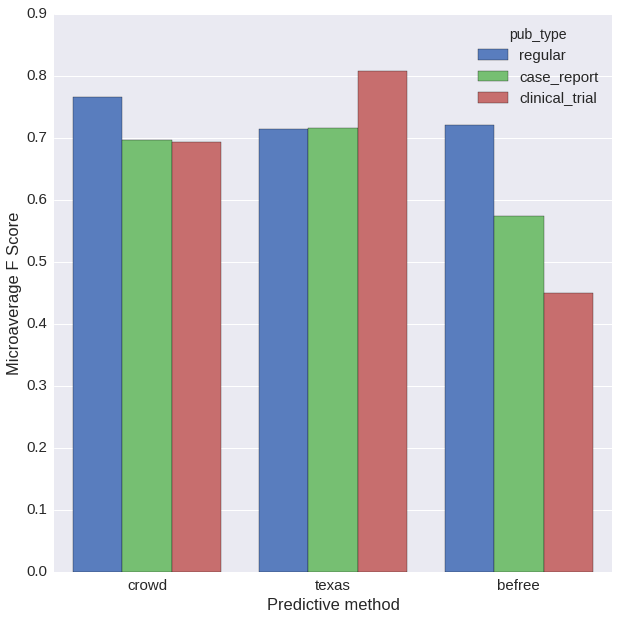

In [84]:
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.set_palette("muted")

fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.barplot(y = "F_score", x = "method", hue = "pub_type", data = temp, ax = ax)
ax.set_ylabel("Microaverage F Score")
ax.set_xlabel("Predictive method")

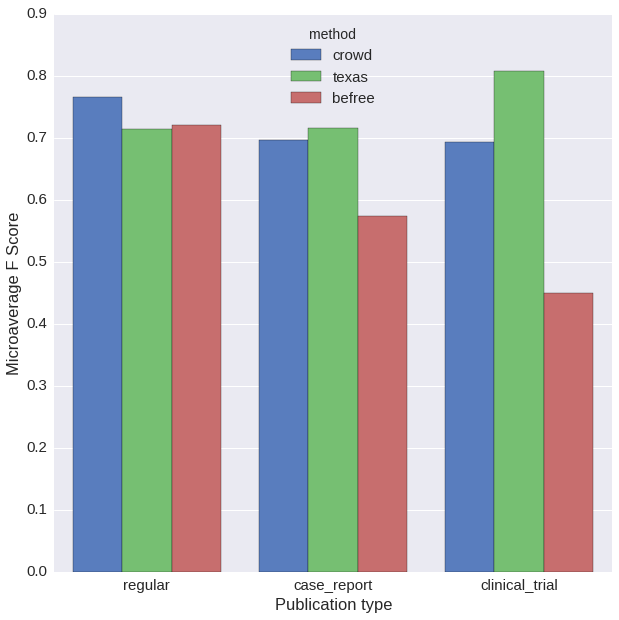

In [86]:
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.set_palette("muted")

fig, ax = plt.subplots(figsize = (10, 10))
ax = sns.barplot(y = "F_score", x = "pub_type", hue = "method", data = temp, ax = ax)
ax.set_ylabel("Microaverage F Score")
ax.set_xlabel("Publication type")

---

In [57]:
common = gold_triples & crowd_trip & texas_trip & befree_trip

In [58]:
len(common)

277

In [59]:
common = make_df(common)

In [60]:
common.head()

,pmid,chemical_id,disease_id
0,3833372,MESH:D006852,MESH:D004244
1,12865514,MESH:D007980,MESH:D004409
2,1158089,MESH:D013752,MESH:D005234
3,16801510,MESH:D008691,MESH:D008133
4,3191389,MESH:D010862,MESH:D012640


In [61]:
common.loc[:, "rel_origin"] = common.loc[:, TRIPLE].apply(
    lambda row: rel_origin(single_triple(row), eval_gold[row["pmid"]]), axis = 1
)

In [62]:
common.head()

,pmid,chemical_id,disease_id,rel_origin
0,3833372,MESH:D006852,MESH:D004244,abs
1,12865514,MESH:D007980,MESH:D004409,sent
2,1158089,MESH:D013752,MESH:D005234,sent
3,16801510,MESH:D008691,MESH:D008133,sent
4,3191389,MESH:D010862,MESH:D012640,sent


In [63]:
common["rel_origin"].value_counts()

sent         252
abs           22
sent|sent      3
dtype: int64

In [64]:
common.query("rel_origin == 'sent|sent'")

,pmid,chemical_id,disease_id,rel_origin
62,10726030,MESH:D006493,MESH:D013921,sent|sent
79,24733133,MESH:D006493,MESH:D013921,sent|sent
127,7739955,MESH:D002220,MESH:D009205,sent|sent


In [65]:
255/277

0.9205776173285198

In [66]:
def converter(pmid, poss_relations):
    return [Relation(pmid, rel[0], rel[1]) for rel in poss_relations]

def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "CID",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return "|".join(ans)

In [67]:
rel_origin((7739955, "MESH:D002220", "MESH:D009205"), eval_gold[7739955])

'CID|sent'

In [68]:
crowd_summary = make_summary(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold)

cols = crowd_summary.columns | ["unit_ids", "num_votes"]

crowd_summary = pd.merge(crowd_summary,
    pd.concat([sent_res, abs_res]), how = "left", on = TRIPLE)[cols]

### T-test of length for abstract scope errors

For the relations which are abstract scoped, does crowd performance depend upon how long the abstracts are? I.e., do workers perform worse on longer abstracts because there's more reading?

In [69]:
def test_length(pred_res, gold_std, gold_full, test, test_type):
    """Apply the Student's t-test to see if the category an
    abstract relation falls into is determined by the length
    of the abstract or the number of sentences.
    """
    assert test in ["length", "sentences"]
    
    res = dict()    
    for e_type, sub in category_splitter(pred_res, gold_std, " and rel_origin == 'abs'"):
        papers = list(sub["pmid"])
        if test == "length":
            res[e_type] = pd.Series([
                len(gold_full[pmid].title) + len(gold_full[pmid].abstract) + 1
                for pmid in papers
            ])
        elif test == "sentences":
            res[e_type] = pd.Series([
                len(gold_full[pmid].sentences) for pmid in papers
            ])
        
    two_samp_test(res, test_type)

In [70]:
test_length(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "length", "t.test")

t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = 1.4014, df = 159.92, p-value = 0.163
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -41.2189 242.6632
sample estimates:
mean of x mean of y 
 1364.662  1263.940 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = -1.9551, df = 129.78, p-value = 0.05272
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -328.40695    1.94666
sample estimates:
mean of x mean of y 
 1364.662  1527.892 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = -3.3129, df = 129.25, p-value = 0.001198
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -421.5881 -106.3165
sample estimates:
mean of x mean of y 
 1263.940  1527.892 


-----------------------------


In [71]:
test_length(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "length", "wilcox.test")

wilcox.test between TP and FP

	Wilcoxon rank sum test with continuity correction

data:  0
W = 4182, p-value = 0.1425
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between TP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 2004.5, p-value = 0.09099
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between FP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 2300.5, p-value = 0.001543
alternative hypothesis: true location shift is not equal to 0


-----------------------------


In [72]:
test_length(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "sentences", "t.test")

t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = 0.75537, df = 165.67, p-value = 0.4511
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.6210935  1.3908233
sample estimates:
mean of x mean of y 
 9.864865  9.480000 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = -1.8031, df = 122.4, p-value = 0.07384
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.3168117  0.1080799
sample estimates:
mean of x mean of y 
 9.864865 10.969231 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = -2.4676, df = 125.71, p-value = 0.01495
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.6835931 -0.2948684
sample estimates:
mean of x mean of y 
  9.48000  10.96923 


-----------------------------


In [73]:
test_length(befree_no_ner, befree_good_gold, eval_gold, "length", "t.test")

t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = -1.3116, df = 80.476, p-value = 0.1934
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -275.64730   56.63352
sample estimates:
mean of x mean of y 
 1447.822  1557.329 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = -0.23017, df = 104.82, p-value = 0.8184
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -204.0291  161.5875
sample estimates:
mean of x mean of y 
 1447.822  1469.043 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = 1.1763, df = 164.1, p-value = 0.2412
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -59.91545 236.48766
sample estimates:
mean of x mean of y 
 1557.329  1469.043 


-----------------------------


#### Crowd:

**Hypothesis**: Workers are more likely to have difficulty with long abstracts due to the amount of reading and long-distance word dependencies.

Based on the t-test results, it seems that there is no difference in length between the true positives and false positives or false negatives. However, there does seem to be a difference in length between the false positives and the false negatives. The false positives were significantly more likely to arise from abstracts which were shorter in length, while the false negatives were more likely to be in longer abstracts.

We see no such evidence of such a dependency in both of the machine learning approaches. Length of the abstract has no bearing on what kind of category the relation will fall into.

Number of sentences has no effect either.

I think that the last result supports the hypothesis that workers are more likely to miss relations in longer abstracts due to more reading and long scale word dependency.

---

### Parallelism test

**Hypothesis**: false positives are likely to show up in sentences containing other true positives.

Example: in PMID 3289726, the gold has three relations, between etoposide (D005047) and three diseases: confusion (D003221), seizure (D012640), and papilledema (D010211). The abstract states: "Significant clinical manifestations have included confusion, papilledema, somnolence, exacerbation of motor deficits, and sharp increase in seizure activity."

Therefore all of the mentioned diseases are related to etoposide. There should in reality be 5 relations in the gold, but one is not possible (motor deficits) because there is no corresponding MeSH term, and the other seems to be a missing relation (a mistake) in the gold standard. However, the missing relation was stated as true with high confidence by our crowd, so we can use this as a filter to find false positives by the crowd which are likely to be true.

In [74]:
def get_concepts(stype, sentence):
    res = set()
    for annot in sentence.annotations:
        if annot.stype == stype:
            res |= annot.uid
        
    return res

def count_parallel(pmid, chem, dise):
    """For a given relation, look at the sentence that the
    disease is in and look for true relations using the
    chemical and another disease in the same sentence.
    
    Usually there is parallelism and the list of diseases
    in the sentence will all be true (as a list of symptoms
    for that chemical etc.)
    
    Example: PMID 3289726, where one sentence contains all the
    true relations.
    """
    paper = eval_gold[pmid]
    
    # find the sentences containing the disease id
    chem_id = Ontology_ID(chem)
    dise_id = Ontology_ID(dise)   
    
    res = 0
    for sentence in paper.sentences:
        concepts = get_concepts("disease", sentence)

        if dise_id in concepts:
            other = concepts - set([dise_id])
            
            poss = [Relation(pmid, frozenset([chem_id]),
                frozenset([concept])) for concept in other]
            
            ans = [int(paper.has_relation(val)) for val in poss]
            res += sum(ans)
            
    return res       

In [75]:
def test_parallel(pred_res, gold_std, gold_full, test_type):
    """Determine whether the category of a relation is independent
    of the number of other parallel relations in the same sentence.
    """
    res = dict()
    for e_type, sub in category_splitter(pred_res, gold_std, " and rel_origin == 'abs'"):
        res[e_type] = pd.Series(sub[TRIPLE].apply(
            lambda r: count_parallel(r["pmid"], r["chemical_id"], r["disease_id"]),
            axis = 1
        ))
        
    two_samp_test(res, test_type)        
    return res

In [76]:
res = test_parallel(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "t.test")

t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = 5.3173, df = 138.49, p-value = 4.119e-07
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.7783989 1.6999795
sample estimates:
mean of x mean of y 
 1.689189  0.450000 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = -0.34741, df = 121.76, p-value = 0.7289
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.7422382  0.5206165
sample estimates:
mean of x mean of y 
 1.689189  1.800000 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = -4.6709, df = 99.281, p-value = 9.427e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -1.9234712 -0.7765288
sample estimates:
mean of x mean of y 
     0.45      1.80 


-----------------------------


In [77]:
res = test_parallel(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold, eval_gold, "wilcox.test")

wilcox.test between TP and FP

	Wilcoxon rank sum test with continuity correction

data:  0
W = 5771, p-value = 1.196e-12
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between TP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 2534, p-value = 0.5759
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between FP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 1923.5, p-value = 9.321e-08
alternative hypothesis: true location shift is not equal to 0


-----------------------------


In [78]:
res["TP"].value_counts()

2    21
0    20
1    18
3     6
6     4
5     3
4     2
dtype: int64

In [79]:
res["FP"].value_counts()

0    83
1     8
3     4
7     3
2     2
dtype: int64

In [80]:
res["FN"].value_counts()

0    29
4    10
1     8
2     7
5     5
6     4
3     2
dtype: int64

In [81]:
fps = crowd_summary.query("~in_gold and in_predict and rel_origin == 'abs'")

fps.loc[:, "link"] = fps.loc[:, "unit_ids"].map(lambda v: "https://crowdflower.com/jobs/767273/units/{}".format(v))

fps.loc[:, "parallel"] = fps.loc[:, TRIPLE].apply(
    lambda r: count_parallel(r["pmid"], r["chemical_id"], r["disease_id"]),
    axis = 1
)

In [82]:
fps.query("parallel > 2").sort("parallel", ascending = False)

,chemical_id,disease_id,in_gold,in_predict,num_votes,pmid,rel_origin,unit_ids,link,parallel
318,MESH:D016190,MESH:D060831,False,True,4,11745287,abs,773937706,https://crowdflower.com/jobs/767273/units/773937706,7
320,MESH:D004317,MESH:D013280,False,True,5,11745287,abs,773937712,https://crowdflower.com/jobs/767273/units/773937712,7
321,MESH:D004317,MESH:D060831,False,True,5,11745287,abs,773937713,https://crowdflower.com/jobs/767273/units/773937713,7
64,MESH:D003613,MESH:D063806,False,True,5,2358093,abs,773936830,https://crowdflower.com/jobs/767273/units/773936830,3
108,MESH:D005047,MESH:D006970,False,True,5,3289726,abs,773936980,https://crowdflower.com/jobs/767273/units/773936980,3
439,MESH:D002231,MESH:D005076,False,True,4,19263707,abs,773938382,https://crowdflower.com/jobs/767273/units/773938382,3
546,MESH:D014635,MESH:D001523,False,True,4,24614773,abs,773936176,https://crowdflower.com/jobs/767273/units/773936176,3


In [83]:
print(fps.query("parallel > 2").sort("parallel", ascending = False))

      chemical_id    disease_id in_gold in_predict  num_votes      pmid  \
318  MESH:D016190  MESH:D060831   False       True          4  11745287   
320  MESH:D004317  MESH:D013280   False       True          5  11745287   
321  MESH:D004317  MESH:D060831   False       True          5  11745287   
64   MESH:D003613  MESH:D063806   False       True          5   2358093   
108  MESH:D005047  MESH:D006970   False       True          5   3289726   
439  MESH:D002231  MESH:D005076   False       True          4  19263707   
546  MESH:D014635  MESH:D001523   False       True          4  24614773   

    rel_origin   unit_ids  \
318        abs  773937706   
320        abs  773937712   
321        abs  773937713   
64         abs  773936830   
108        abs  773936980   
439        abs  773938382   
546        abs  773936176   

                                                    link  parallel  
318  https://crowdflower.com/jobs/767273/units/773937706         7  
320  https://crowdflower.com

Based on the data, we see that the true positive abstract-scope relations usually use diseases which occur in sentences with other diseases which also are related to the current chemical (mean 1.7 other instances). However, with the false positives, this is no longer true (mean 0.45). Based on these data, we propose using the number of parallel relations as a filter for determining errors in the gold standard. As in, relations which were left out in the gold standard, but should really be true because they are in sentences where the other relations were all related to the same chemical. We posit that these relations were missed due to human error. The list is given in the cell above.

---

### Sentence-bound relations

**Hypothesis**: for sentence-bound relations, the crowd performs better when the amount of context increases, that is, the number of tasks (sentences) that the two concepts cooccur in increases. If there is too little context, i.e. only one task (sentence) for a single relation, then we would expect the workers to do poorly because the sentence is taken out of context. In contrast, if there were multiple tasks, then we expect that it is more likely that one of the sentences will have captured the true relationship between the concepts, and therefore giving a higher probability that the crowd will identify the true relation.

Therefore we expect that the category of a relation (TP, FP, FN) will not be independent of the number of sentences.

In [84]:
def test_freq(summary, test_type):
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = summary.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna() # CID relations are filtered out!
        
        print(etype, len(sub))
        
        res[etype] = pd.Series(sub["unit_ids"].map(lambda v: len(v.split("|"))))

    two_samp_test(res, test_type)

In [85]:
test_freq(crowd_summary, "t.test")

TP 188
FP 156
FN 55
t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = 3.3959, df = 340.99, p-value = 0.0007648
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1562751 0.5864964
sample estimates:
mean of x mean of y 
 1.845745  1.474359 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = 3.8217, df = 121.59, p-value = 0.0002104
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.2411333 0.7594470
sample estimates:
mean of x mean of y 
 1.845745  1.345455 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = 0.99852, df = 114.69, p-value = 0.3201
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1268162  0.3846251
sample estimates:
mean of x mean of y 
 1.474359  1.345455 


-----------------------------


In [86]:
test_freq(crowd_summary, "wilcox.test")

TP 188
FP 156
FN 55
wilcox.test between TP and FP

	Wilcoxon rank sum test with continuity correction

data:  0
W = 17874, p-value = 7.472e-05
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between TP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 6680.5, p-value = 0.0002358
alternative hypothesis: true location shift is not equal to 0


-----------------------------
wilcox.test between FP and FN

	Wilcoxon rank sum test with continuity correction

data:  0
W = 4670.5, p-value = 0.2124
alternative hypothesis: true location shift is not equal to 0


-----------------------------


Based on the two sample t-test, it seems that there are significant differences in the number of sentence tasks between the true positives and both false positives and false negatives. There are no differences between the false positive and false negatives. From this I conclude that the null hypothesis is false, and that sentence-scoped relations with greater numbers of tasks are more likely to be classified by the crowd as true positives instead of as either type of error.

Therefore it does seem that a lack of context is affecting crowd performance. When there are more sentences containing the relation pair, it is more likely to be classified properly.

---

### Title sentences

**Hypothesis**: titles are confusing sentences which are more likely to state a tested hypothesis rather than the results of testing that hypothesis. Therefore we hypothesize that the errors are more likely to contain titles than the true positives.

In [87]:
def ttest_title(summary):
    temp = pd.merge(summary, sent_res[TRIPLE + ["sentence_ids"]], how = "left", on = TRIPLE)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    chisqtest = robjects.r["chisq.test"]
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = temp.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna()

        sub.loc[:, "title"] = sub.loc[:, "sentence_ids"].map(
            lambda v:
                sum(int(val == "0") for val in map(lambda f: f.split("_")[1], v.split("|")))
        )
        
        res[etype] = sub["title"].value_counts()[[0, 1]]

    res = pd.DataFrame(res)
    
    print(chisqtest(res))
    return res

In [88]:
ttest_title(crowd_summary)


	Pearson's Chi-squared test

data:  structure(list(FN = structure(c(47L, 8L), .Dim = 2L), FP = structure(c(123L, 33L), .Dim = 2L), TP = structure(c(114L, 74L), .Dim = 2L)), .Names = c("FN", "FP", "TP"), row.names = c("0", "1"), class = "data.frame")
X-squared = 20.116, df = 2, p-value = 4.285e-05




,FN,FP,TP
0,47,123,114
1,8,33,74


We see a significant difference between the distributions, but it seems that this implies that the crowd does better on relations where they were showed the title as a sentence as well. However I think this really means that there were more tasks that the workers saw, which also makes it more likely that the tasks included the title as a sentence task.

In [89]:
def ttest_title2(summary, test_type):
    temp = pd.merge(summary, sent_res[TRIPLE + ["sentence_ids"]], how = "left", on = TRIPLE)
    
    error_type = ["TP", "FP", "FN"]
    vals = [(True, True), (False, True), (True, False)] # gold, predict
    
    res = dict()
    for etype, val in zip(error_type, vals):
        sub = temp.query("in_gold == {} and in_predict == {} and rel_origin == 'sent'".format(
            val[0], val[1])
        ).dropna()
        
        res[etype] = pd.Series(sub.loc[:, "sentence_ids"].map(
            lambda v:
                sum(map(lambda f: int(int(f.split("_")[1]) != 0), v.split("|"))) / len(v.split("|"))
        ))
        
    two_samp_test(res, test_type)

In [90]:
ttest_title2(crowd_summary, "t.test")

t.test between TP and FP

	Welch Two Sample t-test

data:  0
t = -2.2956, df = 333.88, p-value = 0.02232
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.122151721 -0.009413758
sample estimates:
mean of x mean of y 
0.8157801 0.8815629 


-----------------------------
t.test between TP and FN

	Welch Two Sample t-test

data:  0
t = -2.5979, df = 95.959, p-value = 0.01086
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.1752987 -0.0234440
sample estimates:
mean of x mean of y 
0.8157801 0.9151515 


-----------------------------
t.test between FP and FN

	Welch Two Sample t-test

data:  0
t = -0.8633, df = 100.77, p-value = 0.39
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.11077254  0.04359527
sample estimates:
mean of x mean of y 
0.8815629 0.9151515 


-----------------------------


These data tell us that the ratio of non-title sentences to total sentences is closer to 1 (only non-titles) in the false positives and false negatives compared to the true positives. This is the opposite of what we expect based on our original hypothesis that titles are confusing. I think that the titles are perhaps not as big of a deal as we thought, and that the more important factor is that fewer tasks = poorer performance, since there is a loss of context surrounding the sentence.

---

## Manual error analysis

In [91]:
def format_links(df):
    """Format links to CrowdFlower tasks and Pubmed abstracts.
    Expand when multiple tasks.
    """
    assert "rel_origin" in df.columns
    assert "unit_ids" in df.columns
    
    # split any multiplexed unit ids
    df.loc[:, "cf_link"] = df.loc[:, "unit_ids"].map(lambda v: str(v).split("|"))
    
    expanded = expand_df("cf_link", df)
    
    job_id = {
        "abstract_task": 767273,
        "sentence_task": 767262,
        "abs": 767273,
        "sent": 767262,
        "cid_relation": 767262
    }
    
    # take the individual job ids and put them into the appropriate url
    expanded.loc[:, "cf_link"] = expanded.loc[:, ["rel_origin", "cf_link"]].apply(
        lambda v:
            "https://crowdflower.com/jobs/{}/units/{}".format(
                job_id[v["rel_origin"]], v["cf_link"]
            ),
        axis = 1
    )
    
    # make a link to the pubmed page
    expanded.loc[:, "pubmed_link"] = expanded.loc[:, "pmid"].map(
        lambda v: "http://ncbi.nlm.nih.gov/pubmed/?term={}".format(int(v))
    )
    
    return expanded

In [92]:
def manual_inspect(crowd_summary):
    etypes = ["TP", "FP", "FN"]
    ervals = [(True, True), (False, True), (True, False)]

    res = []
    for etype, vals in zip(etypes, ervals):
        for origin in ["sent", "abs"]:
            sub = crowd_summary.query("in_gold == {} and in_predict == {} and rel_origin == '{}'".format(
                vals[0], vals[1], origin)
            ).dropna() # ignore cid relations

            print(etype, origin)

            samp = sub.sample(n = 15, random_state = RAND_KEY)
            samp = format_links(samp)

            samp.loc[:, "etype"] = etype

            res.append(samp)

    return pd.concat(res)

In [93]:
res = manual_inspect(crowd_summary)
res[TRIPLE + ["rel_origin", "num_votes", "pubmed_link", "cf_link", "etype"]].to_excel("errors.xlsx", index = False)

TP sent
TP abs
FP sent
FP abs
FN sent
FN abs


---

### Analysis of manual error sampling

In [94]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval",
    "analysis", "crowd_testset_perfect_ner_errors.xlsx"))

error_res = pd.read_excel(loc)

# drop the crowdflower link column
error_res = error_res.drop("link", axis = 1)

error_res = error_res.query("etype != 'TP'")
error_res = error_res.drop_duplicates()

cols = ["crowd_wrong", "task_limitation", "gold_rel_error"]
error_res.loc[:, cols] = error_res.loc[:, cols].astype(int)

In [95]:
error_res.head()

,pmid,chemical_id,disease_id,rel_origin,num_votes,etype,crowd_wrong,task_limitation,gold_rel_error,error_reason,discussion
44,448423,MESH:D000614,MESH:D013345,sent,4,FP,0,1,0,lack_of_context,Aminocaproic acid and epsilon aminocaproic acid are...
45,1735570,MESH:D014294,MESH:D001919,sent,4,FP,0,0,1,missing_relation,Trimethaphan caused different results depending on ...
46,2907577,MESH:D013806,MESH:D058186,sent,4,FP,1,0,0,lack_of_comprehension,This is both a failure of the crowd's comprehension...
47,3975902,MESH:D001464,MESH:D004342,sent,4,FP,1,0,0,lack_of_comprehension,Disagreement with the gold arises from whether “hyp...
49,3987172,MESH:D010665,MESH:D002543,sent,5,FP,0,0,1,missing_relation,Gold is missing relation.


In [96]:
error_res.query("error_reason == 'lack_of_context'")["etype"].value_counts()

FN    8
FP    1
dtype: int64

In [97]:
lel = error_res.query("gold_rel_error == 1")

In [98]:
lel.shape

(23, 11)

In [99]:
lel.groupby(["rel_origin", "etype"]).groups

{('abs', 'FN'): [106, 108, 112],
 ('abs', 'FP'): [69, 70, 71, 72, 73, 74, 75, 76, 77, 81, 82],
 ('sent', 'FN'): [85, 103],
 ('sent', 'FP'): [45, 49, 52, 55, 56, 58, 66]}

In [100]:
for key, val in lel.groupby(["rel_origin", "etype"]).groups.items():
    print(key)
    print(len(val) / 23)

('sent', 'FP')
0.30434782608695654
('abs', 'FP')
0.4782608695652174
('abs', 'FN')
0.13043478260869565
('sent', 'FN')
0.08695652173913043


In [101]:
kek = test_origin(crowd_no_ner.query("num_votes >= 4"), crowd_good_gold)


	Pearson's Chi-squared test

data:  structure(list(sent = structure(c(55L, 156L, 188L), .Dim = 3L),     abs = structure(c(65L, 100L, 74L), .Dim = 3L)), .Names = c("sent", "abs"), row.names = c("FN", "FP", "TP"), class = "data.frame")
X-squared = 24.075, df = 2, p-value = 5.918e-06




In [102]:
total = 0
for key, val in lel.groupby(["rel_origin", "etype"]).groups.items():
    print(key)
    
    v = kek.loc[key[1], key[0]]
    p = len(val) / 23
    print(v)
    print(v * p)
    total += v * p
    print("\n")
    
print(total)

('sent', 'FP')
156
47.4782608696


('abs', 'FP')
100
47.8260869565


('abs', 'FN')
65
8.47826086957


('sent', 'FN')
55
4.78260869565


108.565217391


In [103]:
116/401

0.2892768079800499

In [104]:
error_res.query("crowd_wrong == 1")["rel_origin"].value_counts()

abs     14
sent     9
dtype: int64

In [105]:
error_res.query("crowd_wrong == 1")["rel_origin"].value_counts(normalize = True)

abs     0.608696
sent    0.391304
dtype: float64

In [106]:
error_res.query("task_limitation == 1")["rel_origin"].value_counts()

sent    12
abs      2
dtype: int64

In [107]:
error_res.query("task_limitation == 1")["rel_origin"].value_counts(normalize = True)

sent    0.857143
abs     0.142857
dtype: float64

In [108]:
error_res.query("gold_rel_error == 1")["rel_origin"].value_counts()

abs     14
sent     9
dtype: int64

In [109]:
for col in ["crowd_wrong", "task_limitation", "gold_rel_error"]:
    sub = error_res.query("{} == 1".format(col))
    print(col)
    
    print(sub["error_reason"].value_counts())
    print("----")
    print(sub["error_reason"].value_counts(normalize = True))
    print("\n")

crowd_wrong
lack_of_comprehension          22
not_covered_by_instructions     1
dtype: int64
----
lack_of_comprehension          0.956522
not_covered_by_instructions    0.043478
dtype: float64


task_limitation
lack_of_context                9
not_covered_by_instructions    3
hierarchy_error                2
dtype: int64
----
lack_of_context                0.642857
not_covered_by_instructions    0.214286
hierarchy_error                0.142857
dtype: float64


gold_rel_error
missing_relation    18
false_relation       5
dtype: int64
----
missing_relation    0.782609
false_relation      0.217391
dtype: float64




In [110]:
error_res.shape

(60, 11)

In [111]:
error_res["gold_rel_error"].sum()

23

In [112]:
error_res["crowd_wrong"].sum()

23

In [113]:
error_res["task_limitation"].sum()

14

In [114]:
error_res["error_reason"].value_counts()

lack_of_comprehension          22
missing_relation               18
lack_of_context                 9
false_relation                  5
not_covered_by_instructions     4
hierarchy_error                 2
dtype: int64

---

In [120]:
# loc = os.path.abspath(os.path.join("..", "data", "final_eval",
#     "analysis", "crowd_testset_perfect_ner_errors.xlsx"))

loc = "toby_all_three_agree_false_pos.xlsx"


error_res = pd.read_excel(loc)

# drop the crowdflower link column
error_res = error_res.drop("cf_link", axis = 1)

error_res = error_res.drop_duplicates()

# cols = ["crowd_wrong", "task_limitation", "gold_rel_error"]
# error_res.loc[:, cols] = error_res.loc[:, cols].astype(int)

In [121]:
error_res

,pmid,chemical_id,disease_id,in_gold,in_crowd,in_befree,in_texas,num_votes,pubmed_link,rel_origin,covered_by_guidelines,gold_error,error_reason,discussion
0,733189,MESH:D010406,MESH:D001766,0,1,1,1,4,http://ncbi.nlm.nih.gov/pubmed/?term=733189,sentence_task,1,0,conjugation,"Penicillin is used in conjugation, but the more imp..."
1,920167,MESH:D014859,MESH:D005315,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=920167,cid_relation,1,0,hierarchy_error,Text states two specific examples of embryopathy wh...
2,1289188,MESH:D003676,MESH:D058186,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=1289188,sentence_task,1,1,hierarchy_error,Gold uses renal insufficiency instead of acute rena...
4,1905439,MESH:D016595,MESH:D006261,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=1905439,sentence_task,0,0,not_main_point,Intro summarizes known research which is not the ma...
5,2553470,MESH:D008094,MESH:D012640,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=2553470,sentence_task,1,0,hierarchy_error,The crux here is whether seizures is a different di...
9,3109094,MESH:D003520,MESH:D003556,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=3109094,cid_relation,1,1,hierarchy_error,Gold used lesions of the urinary bladder instead of...
10,3538855,MESH:D000617,MESH:D058186,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=3538855,sentence_task,1,1,hierarchy_error,Gold seems to have used a less specific disease her...
11,3895875,MESH:D008012,MESH:D006323,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=3895875,sentence_task,0,1,missing_relation,Seems like relation is missing in gold here. The on...
12,7173007,MESH:D003973,MESH:D015746,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=7173007,abstract_task,0,0,ner_error,Endografine and diatrizoate are annotated as two di...
13,8308951,MESH:D014859,MESH:D001778,0,1,1,1,5,http://ncbi.nlm.nih.gov/pubmed/?term=8308951,cid_relation,0,0,intermediate_agent,This is an example of the drug-induced disease dise...


In [122]:
error_res.shape

(25, 14)

In [123]:
error_res["covered_by_guidelines"].value_counts()

1    14
0    11
dtype: int64

In [124]:
error_res["error_reason"].value_counts()

hierarchy_error       10
not_main_point         7
missing_relation       3
ner_error              2
intermediate_agent     2
conjugation            1
dtype: int64

In [125]:
error_res["gold_error"].value_counts()

0    19
1     6
dtype: int64

In [126]:
loc = os.path.abspath(os.path.join("..", "data", "final_eval",
    "analysis", "testset_machine_gold_no_crowd_with_ner_filter.xlsx"))

error_res = pd.read_excel(loc)

# drop the crowdflower link column
error_res = error_res.drop("cf_link", axis = 1)

error_res = error_res.drop_duplicates()

# cols = ["crowd_wrong", "task_limitation", "gold_rel_error"]
# error_res.loc[:, cols] = error_res.loc[:, cols].astype(int)

In [127]:
error_res.shape

(16, 15)

In [128]:
error_res["crowd_wrong"].value_counts()

1    9
0    7
dtype: int64

In [129]:
error_res["task_limitation"].value_counts()

0    12
1     4
dtype: int64

In [130]:
error_res["gold_error"].value_counts()

0    13
1     3
dtype: int64

In [131]:
error_res["rel_origin"].value_counts()

sentence_task    10
abstract_task     6
dtype: int64

In [132]:
error_res.query("crowd_wrong == 1")["rel_origin"].value_counts()

sentence_task    6
abstract_task    3
dtype: int64

In [133]:
(5*9*65000/12)/78263

3.114498549761701

In [134]:
13*60/500

1.56

In [138]:
70 * 9 * 31 * 5

97650

In [139]:
7 * 60 / 500

0.84

### String used to build sankey diagram

Used sankeymatic.com

Relations [30] FP
Relations [30] FN

FP [15] Abstract scoped
FP [15] Sentence scoped
FN [15] Abstract scoped
FN [15] Sentence scoped

Sentence scoped [9] Crowd wrong
Abstract scoped [14] Crowd wrong

Sentence scoped [12] Task limitation
Abstract scoped [2] Task limitation

Sentence scoped [9] Gold mistake
Abstract scoped [14] Gold mistake

Crowd wrong [22] Lack of comprehension
Crowd wrong [1] No instructions

Task limitation [9] Lack of context
Task limitation [3] No instructions
Task limitation [2] Hierarchy error

Gold mistake [18] Missing relation
Gold mistake [5] False relation

false negatives

PMID 753803: vitamin E and muscular dystrophy. Text states that "The authors induced myodystrophy in the rat by giving it a diet lacking in vitamin E." It was not clear that this kind of relation should be treated as the same as "giving aspirin causes cancer". Crowd missed this relation. Could probably have been extracted if we changed the wording of the choice slightly. Did not see this kind of example in the guidelines or the other data, so did not word the choice to capture this variation.

PMID 24927617: telaprevir and rhabdomyolysis. This is an example of where showing the whole abstract instead of just the title would have been better, since the text clearly states that the patient developed the disease after taking the drugs. Workers only saw the title.

PMID 3191389: sodium salicylate and seizures. Single sentence is not enough context. Next sentence says that the chemical converted a non-convulsant dose of pilocarpine to a convulsant one.

---

## Making a supplementary data file

In [113]:
crowd_conc = find_perfect_concepts(crowd_full, eval_gold)
befree_conc = find_perfect_concepts(befree_full, eval_gold)
texas_conc = find_perfect_concepts(texas_full, eval_gold)

common_conc = {
    pmid: tuple([crowd_conc[pmid][i] & befree_conc[pmid][i] & texas_conc[pmid][i] for i in range(2)])
    for pmid in eval_gold.keys()
}

poss_good_trips = get_perf_subset_triples(common_conc)
poss_df = make_df(poss_good_trips)

gold_sub = pd.merge(gold_std, poss_df, how = "inner", on = TRIPLE)
crowd_sub = pd.merge(crowd_res, poss_df, how = "inner", on = TRIPLE)
befree_sub = pd.merge(befree_res, poss_df, how = "inner", on = TRIPLE)
texas_sub = pd.merge(ut_res, poss_df, how = "inner", on = TRIPLE)

In [114]:
all_trips = get_triples(gold_sub) | get_triples(crowd_sub.query("num_votes >= 4")) | get_triples(texas_sub) | get_triples(befree_sub)

venn_summary = make_df(all_trips)

dsets = [get_triples(gold_sub), get_triples(crowd_sub.query("num_votes >= 4")),
         get_triples(texas_sub), get_triples(befree_sub)
]

for col, dset in zip(["gold", "crowd", "texas", "befree"], dsets):
    venn_summary.loc[:, "in_{}".format(col)] = venn_summary.loc[:, TRIPLE].apply(
        lambda r: bool(single_triple(r) in dset),
        axis = 1
    )

In [115]:
def grab_subset(query, df):
    sub = df.query(query)
    
    print("number of relations:", len(sub))
    
    # find out how the crowd voted
    sub = pd.merge(sub, crowd_res[TRIPLE + ["num_votes", "rel_origin"]],
                  how = "left", on = TRIPLE)
    
    # grab the original crowdflower work unit ids
    all_units = pd.concat([sent_res, abs_res])
    sub = pd.merge(sub, all_units[TRIPLE + ["unit_ids"]],
                        how = "left", on = TRIPLE)
    
    # format the links for easy review
    sub = format_links(sub)
    
    return sub.sort(TRIPLE + ["rel_origin"])

In [116]:
def print_excel(df, fname):
    cols = ["pmid", "chemical_id", "disease_id", "in_gold", "in_crowd",
           "in_befree", "in_texas", "num_votes", "pubmed_link", "cf_link", "rel_origin"]    
    
    df[cols].to_excel(fname, index = False)

In [117]:
# relations which both machine learning methods got but our crowd didn't

query = "in_gold and ~in_crowd and in_texas and in_befree"
ml_only = grab_subset(query, venn_summary)
print_excel(ml_only, "machine_gold_no_crowd.xlsx")

number of relations: 16


In [118]:
# relations which both machine learning methods missed but our crowd got

query = "in_gold and in_crowd and ~in_texas and ~in_befree"
crowd_only = grab_subset(query, venn_summary)
print_excel(crowd_only, "crowd_gold_no_machines.xlsx")

number of relations: 36


In [123]:
# relations which all three methods predicted but is not in gold standard

query = "~in_gold and in_crowd and in_texas and in_befree"
all_fp = grab_subset(query, venn_summary)
print_excel(all_fp, "all_false_pos.xlsx")

number of relations: 25


## Concept Venn diagrams

What chemical and disease concepts were identified by each solution?

In [101]:
# what were the MeSH ids of annotations for all papers in the testset?

concepts = defaultdict(lambda: defaultdict(set))

for method, dataset in zip(["gold", "crowd", "befree"], [eval_gold, crowd_full, befree_full]):
    for pmid, paper in dataset.items():
        for annot in paper.annotations:
            concepts[method][annot.stype] |= set(annot.uid)
            
names = ["gold", "crowd", "befree"]
for name in names:
    for concept in ["chemical", "disease"]:
        vals = {val.flat_repr for val in concepts[name][concept]}
        print_to_file("temp/{}_{}.txt".format(name, concept), format_set(vals))

This analysis allows us to determine the performance for each of the NER methods. There may have been some concepts which the NER was never able to recognize properly.

### Chemical MeSH ID overlap for all annotations
<img src="../data/notebook/testset_chemical_id_venn.png" style="width: 500px;">

### Disease MeSH ID overlap for all annotations
<img src="../data/notebook/testset_disease_id_venn.png" style="width: 500px;">


What we thankfully see is that the vast majority of the chemicals and diseases were identified by all three solutions. However, there exist small numbers of both chemicals and diseases for which the solutions could not come into agreement.

### Visualizing the terms in each section of the venn diagrams above

To look at the actual concepts, we can use word clouds where the size represents the frequency of the concept in the annotations of the testset.

In [102]:
mesh_name, hierarchy = load_mesh("hierarchy")
mesh_supp = load_mesh("supp")

assert set(mesh_name.keys()).isdisjoint(set(mesh_supp.keys()))
# join the names together
mesh_name.update(mesh_supp)

In [103]:
def word_map_prep(concepts, reference):
    """Given a set of concepts, map them to their names
    and output for word cloud generation.
    """
    snippets = []
    for pmid, paper in reference.items():
        for annot in paper.annotations:
            common = annot.uid & concepts
            if len(common) > 0:
                for concept in common:
                    if concept.uid_type == "MESH":
                        snippets.append(mesh_name[concept.uid])
                    else:
                        snippets.append(annot.text)
                
    return snippets

For UTexas, sometimes the MeSH ID doesn't match the stated semantic type. For example, in PMID 20009434, "HD" is identified as a disease but is assigned the id D008727 for methotrexate. When finding the frequencies, I am using the identifiers, and not verifying the semantic type. May need to adjust this.

In [104]:
# generate word clouds with worditout, using the table feature for precise control over concepts
# have to save to kemxjr@gmail.com account, then download (watch out for the watermark)

common = concepts["befree"]["chemical"] & concepts["crowd"]["chemical"] - concepts["gold"]["chemical"]

res = word_map_prep(common, crowd_full)

counts = pd.DataFrame(pd.Series(res).value_counts())
counts.to_csv("temp/counts.txt", sep = ":", index = True, header = False)

---

### Venn diagram of relations

In [105]:
# format triples to make venn diagrams using:
# bioinformatics.lu/venn.php
# bioinfogp.cnb.csic.es/tools/venny
        
names = ["gold", "crowd", "befree"]
data = [gold_triples, crowd_trip, befree_trip]
    
for fname, dataset in zip(names, data):
    print_to_file("{}.txt".format(fname), format_set(dataset))

In [106]:
# venn diagram when using only relations with perfect annotations

common_gold = get_triples(crowd_good_gold) | get_triples(befree_good_gold)

names = ["gold", "crowd", "befree"]
data = [common_gold, get_triples(crowd_no_ner.query("num_votes >= 4")), get_triples(befree_no_ner)]
    
for fname, dataset in zip(names, data):
    print_to_file("{}.txt".format(fname), format_set(dataset))

NameError: name 'crowd_good_gold' is not defined

### Gold, crowd, and texas only
<img src="../data/notebook/better_testset_cross_validation.png" style="width: 500px;">

### Gold, crowd, texas, and befree
<img src="../data/notebook/testset_all_cross_validation.png" style="width: 500px;">

### Overlap using relations which had perfect annotations w.r.t. gold
<img src="../data/notebook/testset_all_no_ner_cross_validation.png", style="width: 500px;">

---

### Percent relations in each subset with ids missing in gold standard

In [ ]:
def missing_stats(triples, reference):
    df = make_df(triples)
    df = check_exists(df, reference)
    
    ans = dict()
    for col in ["chem", "dise"]:
        cname = "{}_exists".format(col)
        norm = df[cname].value_counts(normalize = True)
        res = norm.loc[False] if False in norm.keys() else 0
        ans[col] = res * 100
        
    ans["any"] = len(df.query("~chem_exists or ~dise_exists")) / len(df) * 100
    return ans

---

### Abstract vs sentence relations

In [ ]:
def rel_origin(triple, paper):
    relation = Relation(paper.pmid, triple[1], triple[2], flat = False)

    rename = {
        "CID": "CID",
        "sentence_non_CID": "sent",
        "not_sentence_bound": "abs"
    }
    
    ans = []
    for key, val in paper.poss_relations.items():
        value = converter(paper.pmid, val)
        if relation in value:
            ans.append(rename[key])

    return ans

def triple_origin(triples, reference, return_res = False):
    lengths = []
    vals = []
    for trip in triples:
        pmid = trip[0]
        res = rel_origin(trip, reference[pmid])
        
        vals += res
        lengths.append(len(res))
        
    if return_res:
        return pd.Series(vals).value_counts(normalize = True) * 100    
        
    print("For this triple set of length {}".format(len(triples)))
    print("Origin group lengths:")
    print(pd.Series(lengths).value_counts())
    print()
    print("Origin counts:")
    print(pd.Series(vals).value_counts(normalize = True) * 100)

### Relation co-occurrence for each dataset separately

For each technique where did the predicted relations come from?

In [ ]:
a = triple_origin(gold_triples, eval_gold, return_res = True)
b = triple_origin(crowd_trip, crowd_full, return_res = True)
c = triple_origin(befree_trip, befree_full, return_res = True)

rel_origins = pd.DataFrame([a, b, c], index = ["gold", "crowd", "befree"])

ax = rel_origins.T.plot(kind = "bar", figsize = (5, 7),
                    title = "Origin for gold standard, crowd, and texas relations")
ax.set_ylabel("Percent relations")
rel_origins

---

### Make one comprehensive dataframe for easier analysis

In [ ]:
def new_check_exists(df, reference, ref_name):
    triple = ["pmid", "chemical_id", "disease_id"]
    for col in ["chemical", "disease"]:
        col_name = "{0}_in_{1}".format(col[:4], ref_name)
        
        df.loc[:, col_name] = df[triple].apply(
            lambda row: has_concept(reference[int(row["pmid"])], row["{}_id".format(col)]), axis = 1)
        
    return df

In [ ]:
def single_triple_origin(pmid, chemical_id, disease_id, reference):
    triple = (pmid, chemical_id, disease_id)
    
    res = rel_origin(triple, reference[pmid])
    return "|".join(sorted(res))

In [ ]:
def num_times_cooccur(pmid, chemical_id, disease_id, rel_origin, reference):
    """Given a relation triple and a reference Paper object,
    determines how many times the relation cooccurs (a sentence
    if CID or sentence, and 1 otherwise (abstract)).
    """
    if not rel_origin:
        # was not found using this solution
        return np.nan
    
    if rel_origin == "abs":
        return 1
    
    paper = reference[pmid]
    
    rel = Relation(pmid, chemical_id, disease_id, flat = False)
        
    ans = 0
    for sentence in paper.sentences:
        all_rels = sentence.poss_relations[rel_origin == "CID"]
        all_rels = [Relation(pmid, chem_set, dise_set) for chem_set, dise_set in all_rels]
        ans += int(rel in all_rels)
        
    return ans

In [ ]:
# creating one comprehensive dataframe for easy result aggregation and querying

all_trips = gold_triples | crowd_trip | befree_trip
all_df = make_df(all_trips)

triple = ["pmid", "chemical_id", "disease_id"]

# which triple was found by which solution?
for name, reference in zip(["gold", "crowd", "befree"], [gold_triples, crowd_trip, befree_trip]):
    all_df.loc[:, "in_{}".format(name)] = all_df.loc[:, triple].apply(
        lambda row: (row["pmid"], row["chemical_id"], row["disease_id"]) in reference,
        axis = 1
    )
    
# were the concepts present in each dataset's concepts?
for name, reference in zip(["gold", "crowd", "befree"], [eval_gold, crowd_full, befree_full]):
    all_df = new_check_exists(all_df, reference, name)

# was the relation sentence bound or abstract level?
for name, reference in zip(["gold", "crowd", "befree"], [eval_gold, crowd_full, befree_full]):
    colname = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple].apply(
        lambda row: single_triple_origin(row["pmid"], row["chemical_id"], row["disease_id"], reference),
        axis = 1
    )
    
# how many times did the two concepts cooccur within the paper?    
for name, reference in zip(["gold", "crowd", "befree"], [eval_gold, crowd_full, befree_full]):    
    colname = "cooccur_{}".format(name)
    rel_orig = "rel_orig_{}".format(name)
    
    all_df.loc[:, colname] = all_df.loc[:, triple + [rel_orig]].apply(
        lambda row: num_times_cooccur(row["pmid"], row["chemical_id"], row["disease_id"],
                                     row[rel_orig], reference),
        axis = 1
    )

In [ ]:
all_df.head()

In [ ]:
lel = all_df.query("~in_gold and in_crowd and ~in_befree")

In [ ]:
lel.shape

In [ ]:
lel.query("~chem_in_gold or ~dise_in_gold").shape

In [ ]:
162/517

In [ ]:
lel = all_df.query("~in_gold and ~in_crowd and in_befree")

In [ ]:
lel.shape

In [ ]:
lel.query("~chem_in_gold or ~dise_in_gold").shape

In [ ]:
150/312

In [ ]:
lel = all_df.query("~in_gold and in_crowd and ~in_befree and chem_in_gold and dise_in_gold")

In [ ]:
lel.shape

---

### How many of the sentence and abstract relations did each method find? What was the precision?

In [107]:
def found_stats():
    recall = dict()
    precision = dict()
    for method in ["crowd", "befree"]:
        rec_temp = dict()
        pre_temp = dict()
        for rel_type in ["CID", "sent", "abs"]:
            sub = all_df.query("in_gold and rel_orig_gold == '{}'".format(rel_type))
            total = len(sub)
            found = len(sub.query("in_{}".format(method)))
            
            guesses = all_df.query("in_{0} and rel_orig_{0} == '{1}'".format(method, rel_type))
            guesses = len(guesses)
            
            rec_temp[rel_type] = found / total * 100
            pre_temp[rel_type] = found / guesses * 100
            
        recall[method] = rec_temp
        precision[method] = pre_temp
        
    print(recall)
        
    return (pd.DataFrame(recall), pd.DataFrame(precision))

In [108]:
recall, precision = found_stats()

NameError: name 'all_df' is not defined

In [109]:
recall

In [ ]:
  etype origin  crowd_wrong  task_limitation  hierarchy_error  \
0    FN    abs     0.666667         0.133333         0.000000   
1    FN   sent     0.333333         0.733333         0.000000   
2    FP    abs     0.266667         0.133333         0.000000   
3    FP   sent     0.333333         0.200000         0.133333   

   implicit_relation  lack_of_context  ambiguous  lack_of_comprehension  \
0           0.133333         0.000000   0.000000               0.666667   
1           0.000000         0.600000   0.000000               0.133333   
2           0.000000         0.000000   0.000000               0.266667   
3           0.000000         0.066667   0.066667               0.133333   

   ner_error  gold_inconsistent  not_covered_by_instructions  gold_error  
0   0.000000           0.000000                     0.000000    0.200000  
1   0.000000           0.000000                     0.133333    0.133333  
2   0.000000           0.000000                     0.000000    0.733333  
3   0.066667           0.066667                     0.000000    0.466667  

In [110]:
ax = recall.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation recall by relation category")

ax.set_ylabel("Percent gold relations found")

recall

NameError: name 'recall' is not defined

In [111]:
ax = precision.plot(kind = "bar", figsize = (4, 5),
        title = "Gold relation precision by relation category")

ax.set_ylabel("Precision of guesses")

precision

NameError: name 'precision' is not defined

The two solutions found similar fractions of CID and abstract relations. The Texas solution found more sentence relations, but their predictions also contained more sentence-level relations overall. This is bad.. We are showing in different ways why the automated solution was better than our crowd..

### Of the relations which neither technique got, why did we not get them?

In [112]:
unfound = gold_triples - crowd_trip - befree_trip

crowd_miss = missing_stats(unfound, crowd_full)
ut_miss = missing_stats(unfound, befree_full)

missing = pd.DataFrame([crowd_miss, ut_miss], index = ["crowd", "befree"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
             title = "Percent of unfound relations using unknown identifiers")

ax.set_ylabel("Percent of concepts in gold relations with unknown IDs")
missing

NameError: name 'missing_stats' is not defined

So a vast majority of the missed gold relations were unfound mainly because they used an ID which did not appear anywhere in the NER output for that paper.

For the relations which were indexed, what was the scope of the relation?

In [113]:
unfound = all_df.query("in_gold and ~in_crowd and ~in_texas")
crowd_miss = unfound.query("chem_in_crowd and dise_in_crowd")["rel_orig_gold"].value_counts(normalize = True) * 100
texas_miss = unfound.query("chem_in_texas and dise_in_texas")["rel_orig_gold"].value_counts(normalize = True) * 100

missed = pd.DataFrame([crowd_miss, texas_miss], index = ["crowd", "texas"])

ax = missed.T.plot(kind = "bar", figsize = (6, 6),
                title = "Relation scope for indexable but missed gold relations")

ax.set_ylabel("Percent of gold relations")
missed

NameError: name 'all_df' is not defined

For both solutions, at least half of the indexable, missed gold relations were abstract scoped, and therefore likely harder to determine correctly. Texas's solution seems to have a slight bias for the abstract scoped relations, but the different is probably not significant.

---

### For the relations which were false positives, what percentage were due to NER errors?

In [114]:
crowd_only = crowd_trip - gold_triples - befree_trip
befree_only = befree_trip - gold_triples - crowd_trip
crowd_befree = crowd_trip & befree_trip - gold_triples

cr_miss = missing_stats(crowd_only, eval_gold)
befree_miss = missing_stats(befree_only, eval_gold)
both_miss = missing_stats(crowd_befree, eval_gold)

missing = pd.DataFrame([cr_miss, befree_miss, both_miss], index = ["crowd_only", "befree_only", "crowd_and_befree"])

ax = missing.T.plot(kind = "bar", figsize = (7, 7),
                   title = "Percent of false positive relations\nusing IDs not included in gold standard")
ax.set_ylabel("Percent of relations using IDs nonexistent in gold")
missing

NameError: name 'missing_stats' is not defined

A significant number of the false positives for both solutions separately were a result of using MeSH IDs which did not occur in the gold standard. However, the false positives identified by both solutions have a significantly lower rate of NER error, suggesting that these were likely to be real relations which the gold does not include for some reason.

---

### For the gold relations which one solution got but the other missed, why did each solution miss the relations and what kind of relations are they?

In [115]:
crowd_gold = all_df.query("in_gold and in_crowd and ~in_befree")
befree_gold = all_df.query("in_gold and in_befree and ~in_crowd")

crowd_gold = get_triples(crowd_gold)
befree_gold = get_triples(befree_gold)

# unindexable by texas, and by crowd
miss_by_befree = missing_stats(crowd_gold, befree_full)
miss_by_cr = missing_stats(befree_gold, crowd_full)

missing = pd.DataFrame([miss_by_befree, miss_by_cr],
                       index = ["crowd_rels_missed_by_befree", "texas_rels_missed_by_crowd"])
ax = missing.plot(kind = "bar", figsize = (7, 7),
                 title = "Percentage relations found by one solution but\n"
                 "missing in the other due to unindexed concept IDs")
ax.set_ylabel("Percent of relations using IDs\nnot indexable by other method")
ax.set_xticklabels(missing.index, rotation = 0)
missing

NameError: name 'all_df' is not defined

Based on the graph above, we see that the relations which our crowd got but Texas didn't only contained a small subset where the relations contained IDs which were not indexed by Texas. In contrast, a lot of the relations (40%) that Texas got but the crowd didn't were because the IDs were never found, not because the crowd is bad at relation extraction.

---